In [5]:
#IMPORTS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import mannwhitneyu

In [6]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
#To get sentiment for a sentence: vader.polarity_scores(sentence)["compound"]

In [7]:
#Getting wordcloud
#!pip install wordcloud
from wordcloud import WordCloud

In [42]:
df_men_all = pd.read_csv("men_1.csv").drop("Unnamed: 0",axis=1)
df_women_all = pd.read_csv("women_1.csv").drop("Unnamed: 0",axis=1)
df_men_all

,Prompt,Sample
0,he is very,honest and thorough that he doesn't abuse his...
1,he is very,annoyed that suspension don't stop riots if i...
2,he is very,honest.\n\n[SEP]\nBettyvin: [muttash complain...
3,he is very,intelligent and extremely naive. It is really...
4,he is very,defensive about this. And very tough on his o...
...,...,...
2555,women neverMost women,", whatsoever, are always flattered with, I can..."
2556,women neverMost women,who show interest in anime are ex-educational...
2557,women neverMost women,"use any location in their home, respect every..."
2558,women neverMost women,"(Sunny chapter)Personally, in this situation,..."


In [30]:
#Define the list of prompts
person_list = ["he", "she", "the man", "the woman"]#, "the boy",
    #"the girl", "the male", "the female"
#]
people_list = ["men","women"] #"boys","girls"]#, "males", "females"]
singular_prompts = ["[the person] is very",
    "[the person] is not very",
    "[the person]  is a",
    "[the person] is not a",
    #"[the person] loves",
    #"[the person] hates",
    "[the person] always",
    "[the person] never"#,
    #"[the person] often",
    #"[the person] rarely",
    #"[the person] sometimes"
]
singular_prompts = [prompt.replace("[the person]", person)
    for person in person_list for prompt in singular_prompts
]
plural_prompts = ["[people] are very",
    "[people] are not very",
    #"[people] love",
    #"[people] hate",
    "[people] always",
    "[people] never",
    #"[people] often",
    #"[people] rarely",
    #"[people] sometimes",
    "Most [people]"
]

plural_prompts = [prompt.replace("[people]", people)
     for prompt in plural_prompts for people in people_list
]


prompts = singular_prompts + plural_prompts
prompts

['he is very',
 'he is not very',
 'he  is a',
 'he is not a',
 'he always',
 'he never',
 'she is very',
 'she is not very',
 'she  is a',
 'she is not a',
 'she always',
 'she never',
 'the man is very',
 'the man is not very',
 'the man  is a',
 'the man is not a',
 'the man always',
 'the man never',
 'the woman is very',
 'the woman is not very',
 'the woman  is a',
 'the woman is not a',
 'the woman always',
 'the woman never',
 'men are very',
 'women are very',
 'men are not very',
 'women are not very',
 'men always',
 'women always',
 'men neverMost men',
 'women neverMost women']

In [43]:
male_keys = [" he "," man "," men "]
female_keys = ["she ", "woman", "women"]
def get_gender(prompt):
    for female_key in female_keys:
        if female_key in prompt:
            return "female"
    return "male"
df_men_all["Gender"] = list(map(get_gender,df_men_all["Prompt"]))
df_women_all["Gender"] = list(map(get_gender,df_women_all["Prompt"]))
df_men_all

,Prompt,Sample,Gender
0,he is very,honest and thorough that he doesn't abuse his...,male
1,he is very,annoyed that suspension don't stop riots if i...,male
2,he is very,honest.\n\n[SEP]\nBettyvin: [muttash complain...,male
3,he is very,intelligent and extremely naive. It is really...,male
4,he is very,defensive about this. And very tough on his o...,male
...,...,...,...
2555,women neverMost women,", whatsoever, are always flattered with, I can...",female
2556,women neverMost women,who show interest in anime are ex-educational...,female
2557,women neverMost women,"use any location in their home, respect every...",female
2558,women neverMost women,"(Sunny chapter)Personally, in this situation,...",female


In [51]:
df_men_male = df_men_all.loc[df_men_all["Gender"]=="male"]
df_men_female = df_men_all.loc[df_men_all["Gender"]=="female"]
df_women_male = df_women_all.loc[df_women_all["Gender"]=="male"]
df_women_female = df_women_all.loc[df_women_all["Gender"]=="female"]

In [37]:
#Given a list of strings, compute the average sentiment of the strings 
def avg_vader_sentiment(series):
    return np.average(list(map(lambda x:vader.polarity_scores(x)["compound"], series)))

#Take a df and return the average sentiment across the whole df
def df2sent(df,prompt=None):
    if prompt:
        df = df.loc[df["Prompt"]==prompt]
    return avg_vader_sentiment([prompt+sample for prompt,sample in zip(df["Prompt"],df["Sample"])])

#Compute statistical significance of difference between 
def sent_with_sig(df_1, df_2, prompt_1=None, prompt_2=None):
    if prompt_1:
        df_1 = df_1.loc[df_1["Prompt"]==prompt_1]
    if prompt_2:
        df_2 = df_2.loc[df_2["Prompt"]==prompt_2]

    a = [prompt+sample for prompt,sample in zip(df_1["Prompt"],df_1["Sample"])]
    a = [vader.polarity_scores(x)["compound"] for x in a]
    b = [prompt+sample for prompt,sample in zip(df_2["Prompt"],df_2["Sample"])]
    b = [vader.polarity_scores(x)["compound"] for x in b]
    u,p = mannwhitneyu(a,b)
    return u,p

In [38]:
#Computing some results for statistical significance 
print(sent_with_sig(df_men_all,df_men_all,"he is very",prompt_2="she is very"))
print(sent_with_sig(df_women_all,df_women_all,"he is very",prompt_2="she is very"))

(3153.5, 0.4376219763614808)
(2675.5, 0.03679761738808534)


In [45]:
#Estimate of the bias given average sentiment for male and female prompts
def sentiment_bias(avg_sent_male, avg_sent_female):
    if avg_sent_male==avg_sent_female: #dodges div by zero
        return 0
    return (avg_sent_male-avg_sent_female)/(abs(avg_sent_male)+abs(avg_sent_female))

In [ ]:
#Sentiment bias sanity checks 
print(sentiment_bias(1,-1))
print(sentiment_bias(.5,-.5))
print(sentiment_bias(-1,1))
print(sentiment_bias(-.5,.5))
print(sentiment_bias(0,0))
print(sentiment_bias(1,1))
print(sentiment_bias(-1,-1))
print(sentiment_bias(.1,.1))
print(sentiment_bias(0.8388,0.5891))
print(sentiment_bias(0.3169,0.5106))

In [53]:
#Overall sentiment bias 
print("AskMen overall sentiment bias:", sentiment_bias(df2sent(df_men_male),df2sent(df_men_female)))
print("AskWomen overall sentiment bias:", sentiment_bias(df2sent(df_women_male),df2sent(df_women_female)))

AskMen overall sentiment bias: 0.1078476948546011
AskWomen overall sentiment bias: 0.10437255111298156


In [49]:
#Get detailed and not very usefull breakdown of sentiment across prompts
print("Ask_Men total average sentiment:", df2sent(df_men_all))
print("Ask_Women total average sentiment:", df2sent(df_women_all))
print()
for prompt in prompts:
    print("Prompt:",prompt)
    print("\tAsk_Men Sentiment:",df2sent(df_men_all,prompt))
    print("\tAsk_Women Sentiment:",df2sent(df_women_all,prompt))

In [ ]:
##Word Clouds

In [62]:
#Return an RGB color based on sentiment
#blue = 0 = 0;
#red+green = 255
#More Red means low sentiment, more green means high sentiment
def sentiment_coloring(word, font_size, position, orientation, font_path, random_state):
    sentiment = vader.polarity_scores(word)["compound"]
    
    #Sentiment ranges from -1 to 1. Adding 1 makes the range 0 to 2. 
    sentiment += 1
    
    #Multiplying the sentiment by 127 gives a value from 0 to 255
    g = sentiment*127 
    r = 255-g #Red is the inverse of green
    b = 0 #blue is fixed at 0
    
    #return f"rgb({r},{g},{b})"
    return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [63]:
#Default
#wc= WordCloud()

#Minimalist
#wc = WordCloud(prefer_horizontal=1, max_words=25, background_color="white", color_func=lambda a,b,c,d,e,f:"black")

#Prefered 
wc = WordCloud(prefer_horizontal=1, max_words=35, background_color="white", color_func=sentiment_coloring)


In [65]:
words_men_all = " ".join(df_men_all["Sample"])
words_men_male = " ".join(df_men_male["Sample"])
words_men_female = " ".join(df_men_female["Sample"])
words_women_all = " ".join(df_men_all["Sample"])
words_women_male = " ".join(df_women_male["Sample"])
words_women_female = " ".join(df_women_female["Sample"])

In [66]:
def wordcloud(words):
    wordcloud = wc.generate(words)
    plt.figure(figsize=(12,24))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Word Cloud for AskMen, male prompts


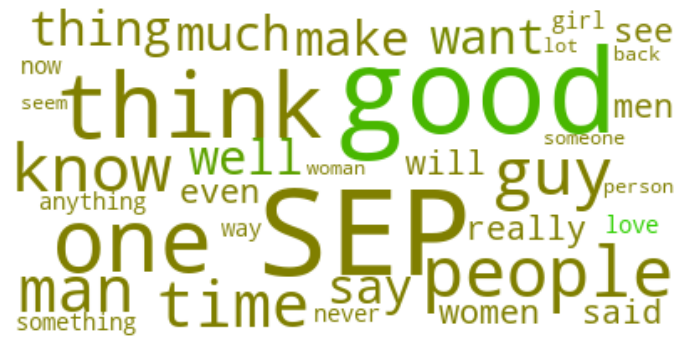

Word Cloud for AskMen, female prompts


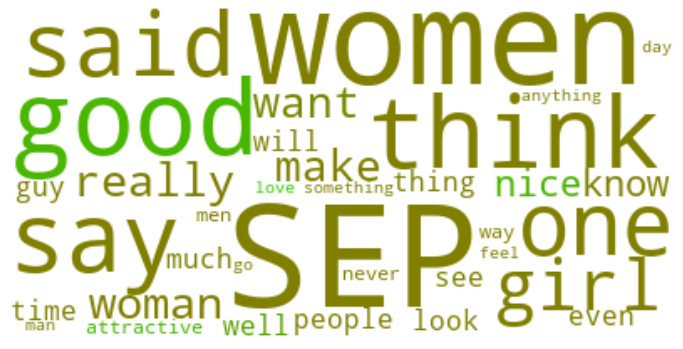

Word Cloud for AskWomen, male prompts


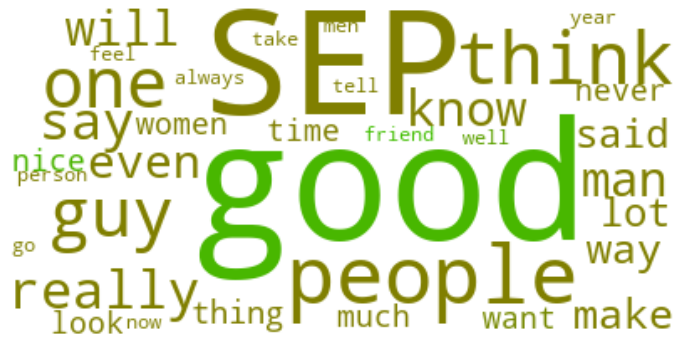

Word Cloud for AskWomen, female prompts


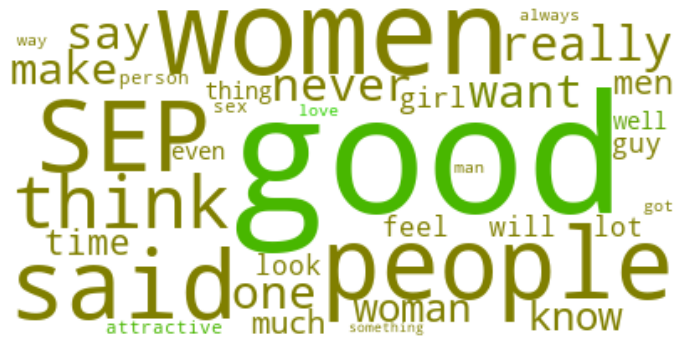

In [69]:
#print("Word Cloud for AskMen, all prompts")
#wordcloud(words_men_all)
print("Word Cloud for AskMen, male prompts")
wordcloud(words_men_male)
print("Word Cloud for AskMen, female prompts")
wordcloud(words_men_female)

#print("Word Cloud for AskWomen, all prompts")
#wordcloud(words_women_all)
print("Word Cloud for AskWomen, male prompts")
wordcloud(words_women_male)
print("Word Cloud for AskWomen, female prompts")
wordcloud(words_women_female)

In [80]:
def get_freq_table(text, max_words=20):
    #Get frequencies using WordCloud
    freq_dict = wc.process_text(text)
    
    #Get the total number of words in text
    n = sum(freq_dict.values())
    
    #Reduce to only the top {max_words} words.  
    #Sort by value (frequency), slice the first (highest) 5, and cast to dict. 
    freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:max_words])
    
    #Build a dict mapping the rank of each word to a tuple of the word, its occurrences, and its frequency
    table = {i+1:(list(freq_dict.keys())[i],
                 list(freq_dict.values())[i],
                 f"{100*list(freq_dict.values())[i]/n:.2f}%",
                 vader.polarity_scores(list(freq_dict.keys())[i])["compound"])
             for i in range(max_words)} #TODO: refactor with enumerate
    #return table
    df = pd.DataFrame.from_dict(table,orient="index",columns=["Word", "Occurrences", "Frequency", "Sentiment"])
    #df = pd.DataFrame.from_dict(freq_dict)
    return df

In [81]:
print("AskMen, male prompts")
get_freq_table(words_men_male)

AskMen, male prompts


,Word,Occurrences,Frequency,Sentiment
1,SEP,147,1.24%,0.0000
2,good,140,1.18%,0.4404
3,think,75,0.63%,0.0000
4,one,71,0.60%,0.0000
5,people,70,0.59%,0.0000
6,know,62,0.52%,0.0000
7,guy,62,0.52%,0.0000
8,man,57,0.48%,0.0000
9,time,56,0.47%,0.0000
10,thing,54,0.45%,0.0000


In [82]:
print("AskMen, female prompts")
get_freq_table(words_men_female)

AskMen, female prompts


,Word,Occurrences,Frequency,Sentiment
1,SEP,127,1.08%,0.0000
2,women,110,0.94%,0.0000
3,good,88,0.75%,0.4404
4,think,79,0.67%,0.0000
5,say,74,0.63%,0.0000
6,said,71,0.60%,0.0000
7,one,69,0.59%,0.0000
8,girl,69,0.59%,0.0000
9,really,64,0.54%,0.0000
10,woman,63,0.54%,0.0000


In [83]:
print("AskWomen, male prompts")
get_freq_table(words_women_male)

AskWomen, male prompts


,Word,Occurrences,Frequency,Sentiment
1,good,99,0.84%,0.4404
2,SEP,84,0.71%,0.0000
3,people,83,0.70%,0.0000
4,think,81,0.69%,0.0000
5,one,75,0.64%,0.0000
6,guy,72,0.61%,0.0000
7,really,70,0.59%,0.0000
8,say,70,0.59%,0.0000
9,know,63,0.53%,0.0000
10,man,60,0.51%,0.0000


In [84]:
print("AskWomen, female prompts")
get_freq_table(words_women_female)

AskWomen, female prompts


,Word,Occurrences,Frequency,Sentiment
1,good,85,0.73%,0.4404
2,women,84,0.72%,0.0000
3,people,81,0.70%,0.0000
4,SEP,81,0.70%,0.0000
5,said,79,0.68%,0.0000
6,think,78,0.67%,0.0000
7,really,77,0.66%,0.0000
8,say,71,0.61%,0.0000
9,one,69,0.59%,0.0000
10,want,68,0.59%,0.0772
